<a href="https://colab.research.google.com/github/claramarto11/AAvanceproject/blob/main/Projeto_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Advanced Automation Project
##Spotify Recommendation System 

**Grupo 17**


*   89855 - Ana Rita Otero
*   90518 - João Passô
*   93502 - Clara Marto
*   96413 - João Alexandre 





Music recommendation systems have become increasingly popular in recent years. With the proliferation of streaming services, users are able to access vast libraries of music, with algorithms providing tailored recommendations. In this project, we will try to create a music recommendation system using Python and the Spotify API in Google Colab, a free cloud-based platform that allows users to code and collaborate.

# Imports needed

In [236]:

# Advanced Automation 2023's Project
# Recommendation Engine & Hit Predictor // Spotify API

!pip install requests
!pip install spotipy

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import numpy as np
import os
import base64
from requests import post, get
import json
import csv
import re


from scipy.stats import pearsonr
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [237]:

import os
import datetime

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore') 

from tqdm import tqdm
from scipy.optimize import curve_fit
from yellowbrick.target import FeatureCorrelation

from sklearn import datasets
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.preprocessing import FunctionTransformer,MinMaxScaler,OneHotEncoder,StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor,BaggingClassifier,BaggingRegressor,RandomForestClassifier,GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse,r2_score,mean_absolute_error,classification_report,confusion_matrix,accuracy_score,auc, roc_curve,accuracy_score
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier,plot_tree
from sklearn.model_selection import train_test_split, StratifiedGroupKFold,StratifiedKFold, GridSearchCV, RandomizedSearchCV,KFold
from sklearn.feature_selection import RFECV,SelectFromModel
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_boston



# Data Extraction

The first step in creating the system is to collect data. In order to do this, the Spotify API can be used to access the necessary information. With the API, we can search for artists, albums, and tracks, as well as access detailed audio features for each track, such as tempo, key, and energy. This data can then be used to create profiles for each track, and these profiles can be used to compare tracks and identify similar ones.

In [161]:
#Authentication 

idj= "011d29dea2f644f78b4f5368ba0d317e"
secretj= "86b22acbd4bf498591b038d69adea504"

client_credentials_manager = SpotifyClientCredentials(client_id=idj, client_secret=secretj)
spj = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

playlist_link1 = "https://open.spotify.com/playlist/1mXeUy5gxuy8juz2oiL5H6?si=537119c577b7402c"
playlist_id1 = playlist_link1.split("/")[-1].split("?")[0]

playlist_link0 = "https://open.spotify.com/playlist/0taMcedcWUKNvRKicX09ZX?si=2c702c6b8a3d44b1"
playlist_id0 = playlist_link0.split("/")[-1].split("?")[0]

playlist_nova = "https://open.spotify.com/playlist/1VPP3PD1M6trW6ephUKEtt?si=b9589d1a1caf4ddc"
playlist_id_nova =playlist_nova.split("/")[-1].split("?")[0]

idr= "295795f897a34beea5e5647da3e24aed"
secretr= "f83912f9833f4d08a4adff6aa6e737c0"

client_credentials_manager = SpotifyClientCredentials(client_id=idr, client_secret=secretr)
spr = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

playlist_linkrita = "https://open.spotify.com/playlist/29sYKlIhyolbVhyudK5q5R?si=202a07665e124cd8&pt=b7c7740f225a0ffc5cf5b2e0f98deda1"
playlist_idrita = playlist_linkrita.split("/")[-1].split("?")[0]

In [162]:
def call_playlistj(playlist_id):
    results = spj.playlist_tracks(playlist_id)
    tracks = results['items']
    while results['next']:
        results = spj.next(results)
        tracks.extend(results['items'])
    results = tracks    

    playlist_tracks_id = []
    playlist_tracks_titles = []
    playlist_tracks_artists = []
    playlist_tracks_first_artists = []
    playlist_tracks_first_release_date = []
    playlist_tracks_popularity = []

    for i in range(len(results)):
        if i == 0:
            playlist_tracks_id = results[i]['track']['id']
            playlist_tracks_titles = results[i]['track']['name']
            playlist_tracks_first_release_date = results[i]['track']['album']['release_date']
            playlist_tracks_popularity = results[i]['track']['popularity']

            artist_list = []
            for artist in results[i]['track']['artists']:
                artist_list= artist['name']
            playlist_tracks_artists = artist_list

            features = spj.audio_features(playlist_tracks_id)
            features_df = pd.DataFrame(data=features, columns=features[0].keys())
            features_df['title'] = playlist_tracks_titles
            features_df['all_artists'] = playlist_tracks_artists
            features_df['popularity'] = playlist_tracks_popularity
            features_df['release_date'] = playlist_tracks_first_release_date
            features_df = features_df[['id', 'title', 'all_artists', 'popularity', 'release_date',
                                       'danceability', 'energy', 'key', 'loudness',
                                       'mode', 'acousticness', 'instrumentalness',
                                       'liveness', 'valence', 'tempo',
                                       'duration_ms', 'time_signature']]
            continue
        else:
            try:
                playlist_tracks_id = results[i]['track']['id']
                playlist_tracks_titles = results[i]['track']['name']
                playlist_tracks_first_release_date = results[i]['track']['album']['release_date']
                playlist_tracks_popularity = results[i]['track']['popularity']
                artist_list = []
                for artist in results[i]['track']['artists']:
                    artist_list= artist['name']
                playlist_tracks_artists = artist_list
                features = spj.audio_features(playlist_tracks_id)
                new_row = {'id':[playlist_tracks_id],
               'title':[playlist_tracks_titles],
               'all_artists':[playlist_tracks_artists],
               'popularity':[playlist_tracks_popularity],
               'release_date':[playlist_tracks_first_release_date],
               'danceability':[features[0]['danceability']],
               'energy':[features[0]['energy']],
               'key':[features[0]['key']],
               'loudness':[features[0]['loudness']],
               'mode':[features[0]['mode']],
               'acousticness':[features[0]['acousticness']],
               'instrumentalness':[features[0]['instrumentalness']],
               'liveness':[features[0]['liveness']],
               'valence':[features[0]['valence']],
               'tempo':[features[0]['tempo']],
               'duration_ms':[features[0]['duration_ms']],
               'time_signature':[features[0]['time_signature']]
               }

                dfs = [features_df, pd.DataFrame(new_row)]
                features_df = pd.concat(dfs, ignore_index = True)
            except:
                continue
                
    return features_df

In [163]:
def call_playlistr(playlist_id):
    results = spr.playlist_tracks(playlist_id)
    tracks = results['items']
    while results['next']:
        results = spr.next(results)
        tracks.extend(results['items'])
    results = tracks    

    playlist_tracks_id = []
    playlist_tracks_titles = []
    playlist_tracks_artists = []
    playlist_tracks_first_artists = []
    playlist_tracks_first_release_date = []
    playlist_tracks_popularity = []

    for i in range(len(results)):
        if i == 0:
            playlist_tracks_id = results[i]['track']['id']
            playlist_tracks_titles = results[i]['track']['name']
            playlist_tracks_first_release_date = results[i]['track']['album']['release_date']
            playlist_tracks_popularity = results[i]['track']['popularity']

            artist_list = []
            for artist in results[i]['track']['artists']:
                artist_list= artist['name']
            playlist_tracks_artists = artist_list

            features = spr.audio_features(playlist_tracks_id)
            features_df = pd.DataFrame(data=features, columns=features[0].keys())
            features_df['title'] = playlist_tracks_titles
            features_df['all_artists'] = playlist_tracks_artists
            features_df['popularity'] = playlist_tracks_popularity
            features_df['release_date'] = playlist_tracks_first_release_date
            features_df = features_df[['id', 'title', 'all_artists', 'popularity', 'release_date',
                                       'danceability', 'energy', 'key', 'loudness',
                                       'mode', 'acousticness', 'instrumentalness',
                                       'liveness', 'valence', 'tempo',
                                       'duration_ms', 'time_signature']]
            continue
        else:
            try:
                playlist_tracks_id = results[i]['track']['id']
                playlist_tracks_titles = results[i]['track']['name']
                playlist_tracks_first_release_date = results[i]['track']['album']['release_date']
                playlist_tracks_popularity = results[i]['track']['popularity']
                artist_list = []
                for artist in results[i]['track']['artists']:
                    artist_list= artist['name']
                playlist_tracks_artists = artist_list
                features = spr.audio_features(playlist_tracks_id)
                new_row = {'id':[playlist_tracks_id],
               'title':[playlist_tracks_titles],
               'all_artists':[playlist_tracks_artists],
               'popularity':[playlist_tracks_popularity],
               'release_date':[playlist_tracks_first_release_date],
               'danceability':[features[0]['danceability']],
               'energy':[features[0]['energy']],
               'key':[features[0]['key']],
               'loudness':[features[0]['loudness']],
               'mode':[features[0]['mode']],
               'acousticness':[features[0]['acousticness']],
               'instrumentalness':[features[0]['instrumentalness']],
               'liveness':[features[0]['liveness']],
               'valence':[features[0]['valence']],
               'tempo':[features[0]['tempo']],
               'duration_ms':[features[0]['duration_ms']],
               'time_signature':[features[0]['time_signature']]
               }

                dfs = [features_df, pd.DataFrame(new_row)]
                features_df = pd.concat(dfs, ignore_index = True)
            except:
                continue
                
    return features_df

In [164]:
df1r=call_playlistr(playlist_idrita)
df1r.to_csv('Playlist_rita_1.csv')
df1j=call_playlistj(playlist_id1)
df0j=call_playlistj(playlist_id0)
df0r= pd.concat([df1j, df0j])
df0r.to_csv('Playlist_rita_0.csv')
dfnova=call_playlistj(playlist_id_nova)
dfnova.to_csv('Playlist_nova.csv')

# Data Processing

In [165]:
df1= pd.read_csv('Playlist_rita_1.csv')
df1["like"]=1
df1 = df1.drop_duplicates(subset='id', keep="first").reset_index()

df0= pd.read_csv('Playlist_nova.csv')
df0["like"]=0
df0 = df0.drop_duplicates(subset='id', keep="first").reset_index()

df= pd.concat([df1, df0])
df = df.drop_duplicates(subset='id', keep="first").reset_index()
df=df.drop(['Unnamed: 0','index','level_0'], axis=1)
df['release_date']= pd.to_datetime(df["release_date"],yearfirst=False)
df['release_date']= pd.DatetimeIndex(df['release_date']).year
df['popularity']=df['popularity']*0.01
df_sample=df.drop(['id','instrumentalness','title','all_artists','mode', 'duration_ms','release_date'
                          ,'key', 'time_signature','tempo','loudness'], axis=1)
df_sample

,popularity,danceability,energy,acousticness,liveness,valence,like
0,0.75,0.795,0.630,0.041900,0.0894,0.7850,1
1,0.65,0.539,0.240,0.687000,0.1330,0.5670,1
2,0.86,0.617,0.635,0.049800,0.1640,0.4460,1
3,0.42,0.572,0.898,0.154000,0.2320,0.4940,1
4,0.37,0.447,0.781,0.056400,0.2040,0.7400,1
...,...,...,...,...,...,...,...
1160,0.14,0.700,0.651,0.000057,0.0708,0.0425,0
1161,0.56,0.765,0.889,0.000457,0.0912,0.0947,0
1162,0.13,0.766,0.923,0.001080,0.1050,0.0720,0
1163,0.15,0.760,0.841,0.004000,0.1120,0.0680,0


In [166]:
df_play = pd.read_csv('Playlist_rita_0.csv')
df_guess=df_play.copy()
df_guess = df_guess.drop_duplicates(subset='id', keep="first").reset_index()
df_guess=df_guess.drop(['index','Unnamed: 0','id','title','all_artists','mode', 'duration_ms',
                          'key', 'time_signature','tempo'], axis=1)
df_guess['release_date']= pd.to_datetime(df_guess["release_date"],yearfirst=False)
df_guess['release_date']= pd.DatetimeIndex(df_guess['release_date']).year
df_guess['popularity']=df_guess['popularity']*0.01

df_guess
# Checking for null values
#df.isnull().any()

,popularity,release_date,danceability,energy,loudness,acousticness,instrumentalness,liveness,valence
0,0.73,1969,0.396,0.338,-10.872,0.19800,0.000003,0.1380,0.377
1,0.68,1969,0.422,0.656,-8.412,0.01260,0.027900,0.2680,0.549
2,0.66,1969,0.626,0.512,-9.150,0.15500,0.000046,0.2150,0.730
3,0.63,1969,0.370,0.515,-9.487,0.02330,0.205000,0.0966,0.420
4,0.47,1969,0.605,0.536,-10.069,0.51800,0.000000,0.5280,0.688
...,...,...,...,...,...,...,...,...,...
476,0.78,1977,0.721,0.521,-8.123,0.07080,0.005450,0.1270,0.942
477,0.00,2020,0.454,0.567,-6.317,0.03950,0.000877,0.3160,0.382
478,0.00,2020,0.589,0.573,-7.727,0.00244,0.261000,0.1370,0.542
479,0.00,2021,0.656,0.881,-5.059,0.39000,0.000010,0.1400,0.346


In [167]:
# Checking for duplicate entries
df[df.duplicated()]

,id,title,all_artists,popularity,release_date,danceability,energy,key,loudness,mode,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,like


# Data Analysis


Once the data has been collected, it needs to be analyzed. This can be done by using various Python libraries, such as NumPy and Pandas, to manipulate and analyze the data. Specifically, we can use clustering algorithms to group similar tracks together, and collaborative filtering to identify tracks that are likely to be liked by a particular user.

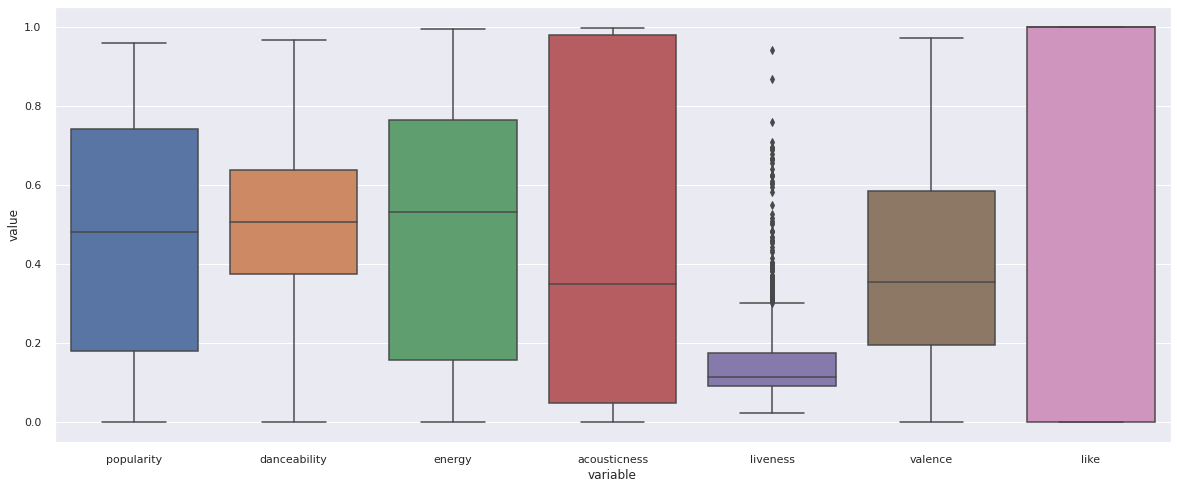

In [168]:
## Boxplots of ones
df_sample['idx'] = np.arange(df_sample.shape[0])
df_sample = df_sample.melt(id_vars='idx')

## Figure size
sns.set(rc={"figure.figsize":(20, 8)})
## Plot
ax = sns.boxplot(x="variable", y="value",data=df_sample)

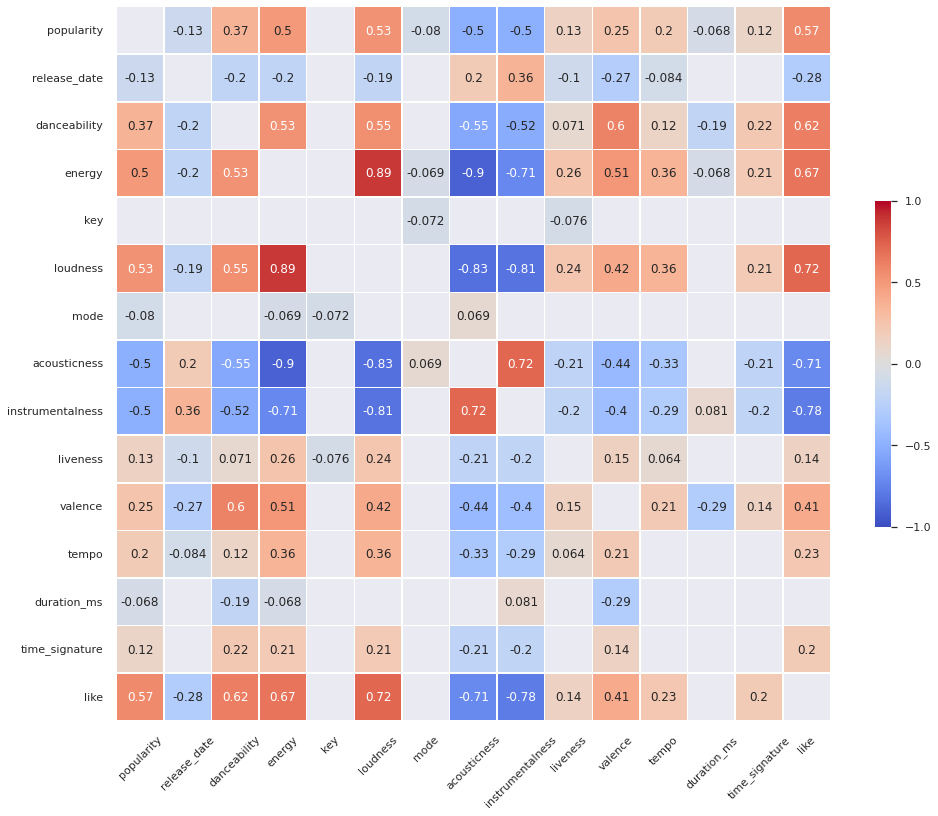

In [169]:
## Calculate correlation matrix and p-values of ones
corr_matrix = df.corr()
pval = df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*corr_matrix.shape)

# Create a filter (diagonal, triangle, or null)
mask_type = 'diagonal'
if mask_type == 'triangle':
    base_mask = np.zeros_like(corr_matrix, dtype=np.bool)
    base_mask[np.triu_indices_from(base_mask)]= True
elif mask_type == 'diagonal':
    base_mask = np.eye(corr_matrix.shape[0])
elif mask_type == 'null':
    base_mask = np.zeros([corr_matrix.shape[0], corr_matrix.shape[0]])
    
## If statistically significant filter is to be included
include_stat_sig = True
if include_stat_sig:
    mask = base_mask
    stat_sig = pval > 5/100
    for i in range(pval.shape[0]):
        for j in range(pval.shape[0]):
            mask[i,j] = base_mask[i,j] or stat_sig.iloc[i,j]

f, ax = plt.subplots(figsize=(16, 15)) 
heatmap = sns.heatmap(
    corr_matrix,
    mask = base_mask,
    square = True,
    linewidths = .5,
    cmap = 'coolwarm',
    cbar_kws = {'shrink': .4, 'ticks' : [-1, -.5, 0, 0.5, 1]},
    vmin = -1, 
    vmax = 1,
    annot = True,
    annot_kws = {"size": 12})
#add the column names as labels
ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns, rotation = 45)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

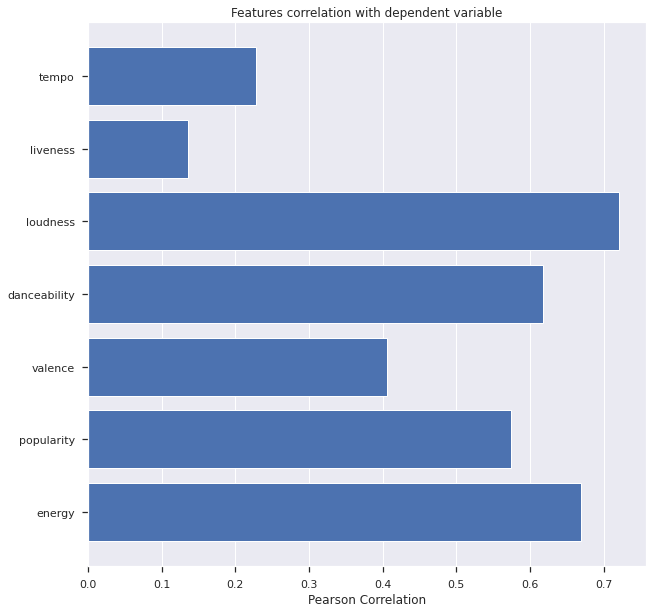

In [234]:
feature_names =["energy", "popularity","valence","danceability",'loudness','liveness','tempo']
X, y = df[feature_names], df['like']
features = np.array(feature_names)
visualizer = FeatureCorrelation(labels=features)
plt.rcParams['figure.figsize']=(10,10)
visualizer.fit(X, y)    
visualizer.show()

In [231]:
fig = px.scatter_matrix(df,
    dimensions=["energy", "popularity","valence","danceability",'loudness','energy'],
    color="like")
fig.update_traces(diagonal_visible=False)
fig.show()

In [228]:
fig = px.scatter(df, x="popularity", y="energy", color="like", size='duration_ms',
                 hover_data=['id', 'title', 'all_artists', 'release_date', 'danceability', 'energy', 'key', 
                             'loudness', 'mode', 'acousticness', 
                             'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature'])
fig.show()

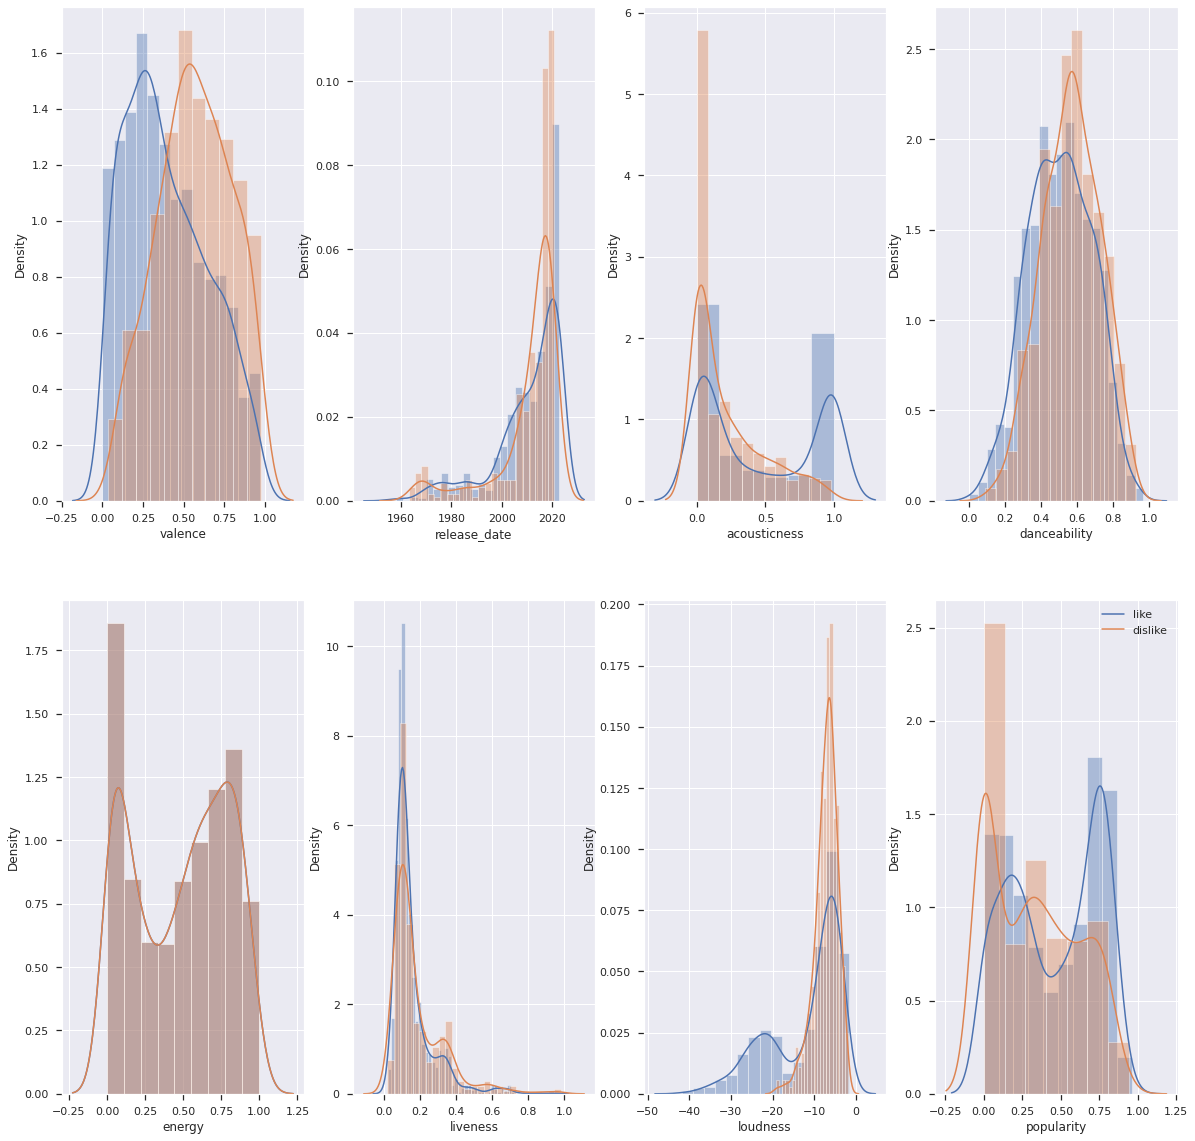

In [175]:
##Visualisation of Variability for each column in the dataframe
fig,ax = plt.subplots(2,4,figsize=(20,20))
sns.distplot(df['valence'],ax=ax[0,0])
sns.distplot(df_guess['valence'],ax=ax[0,0])
sns.distplot(df['release_date'],ax=ax[0,1])
sns.distplot(df_guess['release_date'],ax=ax[0,1])
sns.distplot(df['acousticness'],ax=ax[0,2])
sns.distplot(df_guess['acousticness'],ax=ax[0,2])
sns.distplot(df['danceability'],ax=ax[0,3])
sns.distplot(df_guess['danceability'],ax=ax[0,3])
sns.distplot(df['energy'],ax=ax[1,0])
sns.distplot(df['energy'],ax=ax[1,0])
sns.distplot(df['liveness'],ax=ax[1,1])
sns.distplot(df_guess['liveness'],ax=ax[1,1])
sns.distplot(df['loudness'],ax=ax[1,2])
sns.distplot(df_guess['loudness'],ax=ax[1,2])
sns.distplot(df['popularity'],ax=ax[1,3])
sns.distplot(df_guess['popularity'],ax=ax[1,3])
plt.legend(labels=['like','dislike'])

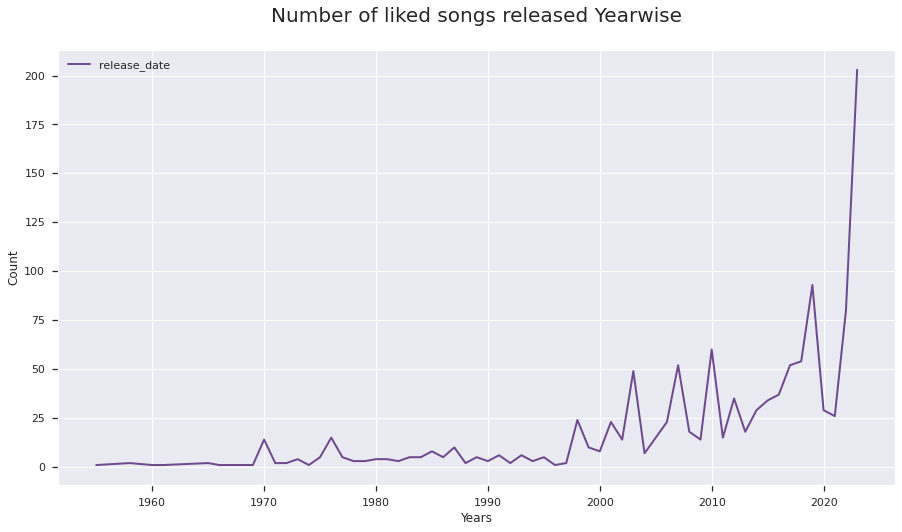

In [177]:
year = pd.DataFrame(df['release_date'].value_counts())
year = year.sort_index()
ax=year.plot(kind='line',figsize=(15,8) ,color='#6f4a8e', linewidth=2)
plt.title("Number of liked songs released Yearwise",y=1.05,fontsize=20)
plt.xlabel('Years')
plt.ylabel('Count')
ax.axes.get_xaxis().set_visible(True)

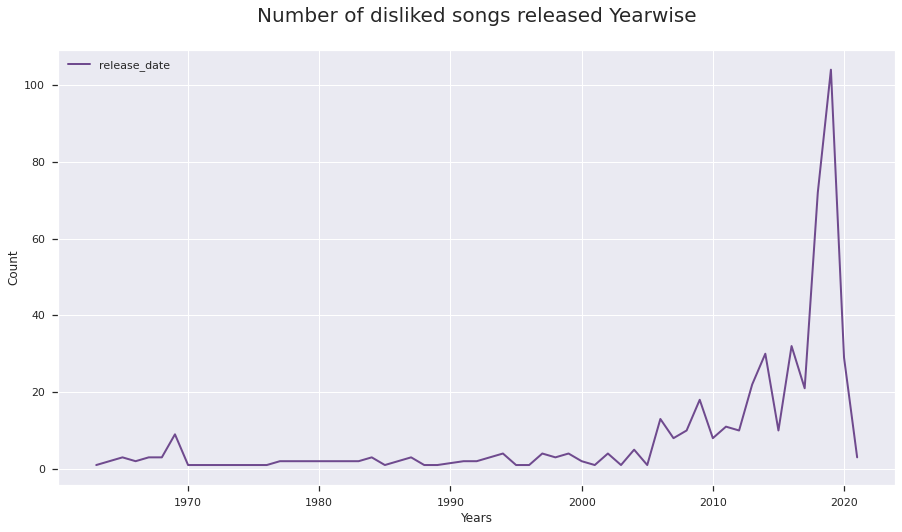

In [178]:
year = pd.DataFrame(df_guess['release_date'].value_counts())
year = year.sort_index()
ax=year.plot(kind='line',figsize=(15,8) ,color='#6f4a8e', linewidth=2)
plt.title("Number of disliked songs released Yearwise",y=1.05,fontsize=20)
plt.xlabel('Years')
plt.ylabel('Count')
ax.axes.get_xaxis().set_visible(True)

# Implementation

Once the data has been collected and analyzed, the system can be implemented. This can be done using the Python library Scikit-Learn, which provides a variety of machine learning algorithms.

In [179]:
df_guess=df_guess.drop(['release_date'], axis=1)
#Split the data to train and test
test_ptg = 0.3
seed = 100
df_copy=df.drop(['id','title','all_artists','mode', 'duration_ms',
                          'key', 'time_signature','tempo','release_date'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(df_copy.drop('like', axis=1), df_copy['like'], test_size = 0.3, random_state = 42)
X_train

,popularity,danceability,energy,loudness,acousticness,instrumentalness,liveness,valence
810,0.30,0.312,0.30400,-20.251,0.976000,0.844000,0.1650,0.357
533,0.76,0.589,0.38400,-15.075,0.112000,0.000028,0.0596,0.354
964,0.52,0.177,0.60400,-10.341,0.430000,0.932000,0.1110,0.126
602,0.25,0.808,0.89700,-3.712,0.046900,0.000031,0.3640,0.591
803,0.31,0.242,0.22500,-24.526,0.971000,0.955000,0.1940,0.705
...,...,...,...,...,...,...,...,...
1044,0.02,0.417,0.00699,-34.098,0.996000,0.921000,0.0979,0.229
1095,0.56,0.414,0.93000,-2.411,0.000008,0.031100,0.2180,0.214
1130,0.23,0.459,0.79500,-5.486,0.146000,0.000000,0.1220,0.411
860,0.22,0.392,0.05090,-21.172,0.985000,0.763000,0.0918,0.213


# Logistic Regression

Logistic regression is a popular machine learning technique used to predict the outcome of a categorical dependent variable, such as whether a customer will like a song, based on more than one independent variables. This type of regression is a supervised learning algorithm, meaning that it requires labeled data in order to be effective.

The relationship between the independent variables and the dependent variable is reached by using a probability formula. This probability formula is used to calculate the likelihood that a given observation belongs to one of the categories (or classes) of the dependent variable. This likelihood is then used to make predictions about new data points.

Logistic regression has some advantages over other regression techniques. It is able to handle non-linear relationships between independent and dependent variables and can handle large datasets with many features. Logistic regression is also robust to outliers, meaning that it is less affected by extreme values in the data. Finally, it is relatively simple to implement and interpret.

Despite its advantages, logistic regression has some drawbacks. It is limited to modeling binary dependent variables (i.e., those with only two possible outcomes), and is sensitive to imbalanced datasets. Is a powerful machine learning technique that has a wide range of applications. It is useful for making predictions about binary dependent variables, and is relatively simple to implement and interpret. However, it does have some drawbacks, such as its sensitivity to imbalanced datasets and its tendency to overfit.

In [180]:
## Logistic Regression

model = LogisticRegression(max_iter = 1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print ('\n' + 'Real'.rjust(23))
print ('{} | {}'.format('0'.rjust(19), '1'))
print ('{}:  {} | {}'.format('Previsto 0'.rjust(14), cm[0,0], cm[1,0]))
print ('{}:  {} | {}'.format('Previsto 1'.rjust(14), cm[0,1], cm[1,1]))
print ('Success Rate: {:.2f}%'.format(accuracy_score(y_pred, y_test)*100))


                   Real
                  0 | 1
    Previsto 0:  81 | 7
    Previsto 1:  13 | 132
Success Rate: 91.42%


In [181]:
# Logistic Regression

minmax_scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(minmax_scaler.fit_transform(X_train), columns=X_train.columns)

lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)
print(classification_report(y_test, lr.predict(X_test)))

              precision    recall  f1-score   support

           0       0.41      1.00      0.58        94
           1       1.00      0.01      0.03       139

    accuracy                           0.41       233
   macro avg       0.70      0.51      0.30       233
weighted avg       0.76      0.41      0.25       233



# KNN


The K-nearest neighbors (KNN) method is a machine learning algorithm used for classification and regression. It is one of the most popular and widely used supervised learning algorithms. KNN is based on the principle of distance in feature space. It is a non-parametric and lazy learning algorithm, meaning that it does not require any prior knowledge or assumptions about the data.

The KNN algorithm is based on the idea that similar data points should be grouped together. Given a new data point, the algorithm finds the k-nearest neighbors (or data points) in the training set and uses their labels to determine the label for the new point. It then assigns the new point a label based on the majority vote of its k-nearest neighbors.

It is simple to implement and interpret, and can be used for both classification and regression tasks. It is also robust to noisy data and is not affected by outliers. Additionally, it does not require any assumptions about the data and can handle high-dimensional datasets.

It is computationally expensive and can be slow to make predictions. Additionally, it is sensitive to the choice of k and to features with different scales. Finally, it can be prone to overfitting if the training data is not properly cleaned and preprocessed.

Overall, the KNN algorithm is a powerful machine learning algorithm that is useful for both classification and regression tasks. It is simple to implement and interpret, and is robust to noisy data and outliers. However, it is computationally expensive and can be prone to overfitting if the training data is not properly cleaned and preprocessed.

In [182]:
# KNN Classifier
knn = KNeighborsClassifier(n_jobs=-1)
knn_gcv_params = {'n_neighbors': range(1, 10)}

knn_gcv = GridSearchCV(knn, knn_gcv_params, n_jobs=-1, cv=StratifiedKFold(2), verbose=1, scoring='roc_auc')
knn_gcv.fit(X_train, y_train)
knn_gcv.best_params_, knn_gcv.best_score_

Fitting 2 folds for each of 9 candidates, totalling 18 fits


({'n_neighbors': 6}, 0.9467073516889015)

In [183]:
print(classification_report(y_test, knn_gcv.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      0.87      0.90        94
           1       0.92      0.96      0.94       139

    accuracy                           0.92       233
   macro avg       0.92      0.91      0.92       233
weighted avg       0.92      0.92      0.92       233



K Value: 1 -- Test Error: 8.58%
K Value: 2 -- Test Error: 10.30%
K Value: 3 -- Test Error: 8.15%
K Value: 4 -- Test Error: 9.01%
K Value: 5 -- Test Error: 8.15%
K Value: 6 -- Test Error: 7.73%
K Value: 7 -- Test Error: 9.01%
K Value: 8 -- Test Error: 8.15%
K Value: 9 -- Test Error: 8.58%
K Value: 10 -- Test Error: 8.15%
K Value: 11 -- Test Error: 9.01%
K Value: 12 -- Test Error: 9.44%
K Value: 13 -- Test Error: 11.16%
K Value: 14 -- Test Error: 11.16%
K Value: 15 -- Test Error: 11.59%
K Value: 16 -- Test Error: 11.16%
K Value: 17 -- Test Error: 12.02%
K Value: 18 -- Test Error: 12.02%
K Value: 19 -- Test Error: 12.45%
K Value: 20 -- Test Error: 12.45%


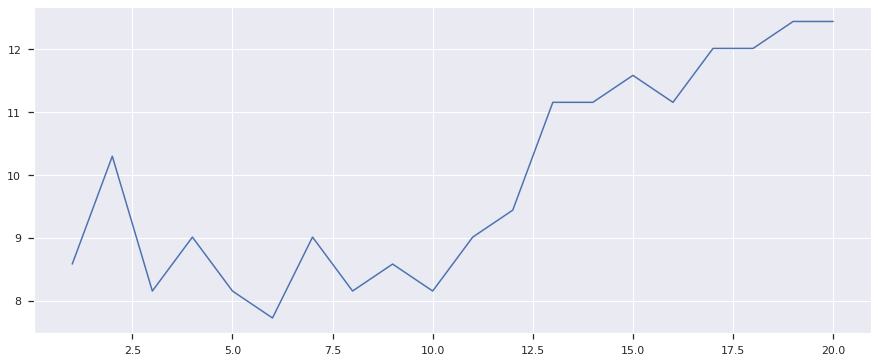

In [184]:
def KNN_fit(X_train, X_test, y_train, y_test, n_neighbors):

  model = KNeighborsClassifier(n_neighbors=n_neighbors)
  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)
  cm = confusion_matrix(y_test, y_pred)
  error_val = 100 - accuracy_score(y_pred, y_test)*100
  print('K Value: {} -- Test Error: {:.2f}%'.format(n_neighbors, error_val))

  return model, error_val

errors = []
n_tests = 20
for i in range(n_tests):
  _, error_val = KNN_fit(X_train, X_test, y_train, y_test, n_neighbors=i+1)
  errors.append(error_val)

plt.subplots(figsize=(15, 6))
plt.plot(range(1,n_tests+1), errors)
plt.show()

# Decision Tree


Decision tree is a supervised learning algorithm used in data mining and machine learning. It is a decision support tool that uses a tree-like structure of decisions and their possible consequences, including chance-event outcomes, resource costs, and utility. It is one of the most popular and effective methods for supervised learning, as it allows for the exploration of all possible outcomes from a given set of data.

Decision tree works by making a series of decisions based on the attributes of the data. It is a tree-like model that begins with a single root node, which is the decision node. From this root node, the algorithm then splits the data into two or more branches based on the attribute values of the data. Each of these branches is then evaluated based on the criteria set by the user. This criteria could include the quality of the predicted outcome, the cost associated with a particular decision, or the utility of the decision.

The decision tree algorithm then makes a prediction based on the data. This prediction is based on the attributes of the data and the criteria set by the user. Once the algorithm makes a prediction, it can be evaluated to determine the accuracy of the prediction. If the accuracy of the prediction is high, the decision tree algorithm can be used to make decisions in more complex situations.

Decision trees are often used in fields such as finance, customer segmentation, marketing, and operations research. They are also used to identify customer segments in retail and healthcare, to identify potential customer needs, and to determine the best pricing strategies for a given product or service.

Decision trees have many advantages over other algorithms. They are simple to understand, require minimal training data, and can be used to make decisions in complex scenarios. They are also efficient, as they can quickly identify the most important attributes of the data.

Overall, decision tree is a powerful and useful tool that can be used to make decisions in a wide variety of scenarios. It is a great way to explore the possible outcomes from a given set of data and to make predictions based on the attributes of the data. With its simplicity and efficiency, it is a great tool for supervised learning.

In [185]:
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

print("Accuracy:",accuracy_score(y_test, y_pred))

Accuracy: 0.9313304721030042


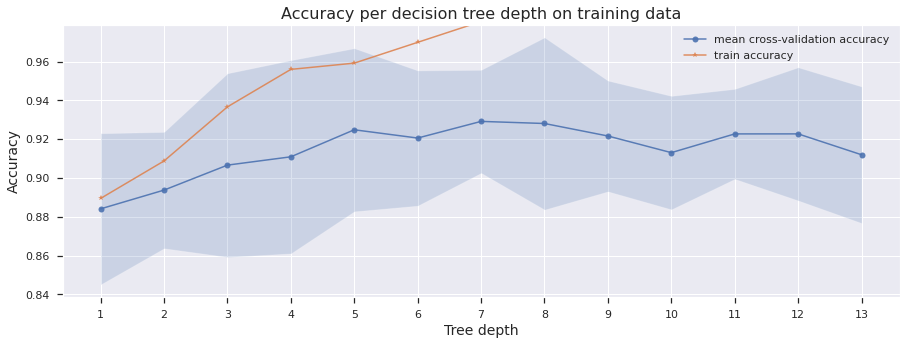

In [186]:
from sklearn.model_selection import cross_val_score

# function for fitting trees of various depths on the training data using cross-validation
def run_cross_validation_on_trees(X, y, tree_depths, cv=5, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        tree_model = DecisionTreeClassifier(max_depth=depth)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores

# function for plotting cross-validation results
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()


# fitting trees of depth 1 to 14
sm_tree_depths = range(1,14)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(X_train, y_train, sm_tree_depths)


# plotting accuracy
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores,'Accuracy per decision tree depth on training data')

In [187]:
idx_max = sm_cv_scores_mean.argmax()
sm_best_tree_depth = sm_tree_depths[idx_max]
sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]
print('The depth-{} tree achieves the best mean cross-validation accuracy {} +/- {}% on training dataset'.format(sm_best_tree_depth, round(sm_best_tree_cv_score*100,5), round(sm_best_tree_cv_score_std*100, 5)))

The depth-7 tree achieves the best mean cross-validation accuracy 92.91933 +/- 1.32932% on training dataset


In [188]:
# function for training and evaluating a tree
def run_single_tree(X_train, y_train, X_test, y_test, depth):
    model = DecisionTreeClassifier(max_depth=depth).fit(X_train, y_train)
    accuracy_train = model.score(X_train, y_train)
    accuracy_test = model.score(X_test, y_test)
    print('Single tree depth: ', depth)
    print('Accuracy, Training Set: ', round(accuracy_train*100,5), '%')
    print('Accuracy, Test Set: ', round(accuracy_test*100,5), '%')
    return accuracy_train, accuracy_test
  

# train and evaluate a 3-depth tree
sm_best_tree_accuracy_train, sm_best_tree_accuracy_test = run_single_tree(X_train, y_train, 
                                                                          X_test, y_test, 
                                                                          sm_best_tree_depth)

Single tree depth:  7
Accuracy, Training Set:  98.06867 %
Accuracy, Test Set:  93.13305 %


In [189]:
def Decision_tree(X_train,y_train,X_test,y_test,min_samples_split,max_leaf_nodes):
  
    tree = DecisionTreeRegressor(max_leaf_nodes =max_leaf_nodes , min_samples_split =min_samples_split )
    tree.fit(X_train, y_train)
    y_train_pred = tree.predict(X_train)
    train_rmse = np.sqrt(mse(y_train, y_train_pred))
    
    y_test_pred = tree.predict(X_test)
    test_rmse = np.sqrt(mse(y_test, y_test_pred))
    
    r2_train = r2_score(y_train, y_train_pred)
    
    r2_test= r2_score(y_test, y_test_pred)
    
    mae = (abs(y_test - y_test_pred)).mean() 
    
    return train_rmse,test_rmse,r2_train,r2_test,y_train_pred,y_test_pred,mae

train_rmse, test_rmse, r2_train, r2_test,y_train_pred,y_test_pred,mae= Decision_tree(X_train,y_train,X_test,y_test,min_samples_split = 200,max_leaf_nodes=167)

print("Root Mean Squared Error for Train dataset is {}".format(train_rmse))
print("Root Mean Squared Error for Test  dataset is {}".format(test_rmse))
print("r2-score for Train Dataset is {}".format(r2_train))
print("r2-score for Test Dataset is {}".format(r2_test))
print("Mean Absolute Error for Test dataset is {}".format(mae))

Root Mean Squared Error for Train dataset is 0.24587256438498412
Root Mean Squared Error for Test  dataset is 0.2827931750563279
r2-score for Train Dataset is 0.7515791332077219
r2-score for Test Dataset is 0.6677178314300635
Mean Absolute Error for Test dataset is 0.1479244396603542




When using a decision tree regressor, GridSearchCV can help to identify the best hyperparameters for the model.

One of the most important factors in decision tree regressors is the choice of hyperparameters. GridSearchCV is an efficient way to search for the optimum combination of hyperparameters to get the best model. GridSearchCV can help to identify the best values of the hyperparameters for the model, which can significantly improve its accuracy and performance.

GridSearchCV also provides cross-validation, which helps to prevent overfitting and ensure that the model is generalizable. Cross-validation helps to ensure that the model performs well on unseen data, since it is tested on a subset of the data that was not used for training. 


In [194]:
RMSE3_train, RMSE3_test = [], []

for i in range(2,200):
    tree = DecisionTreeRegressor(random_state = 15, max_leaf_nodes=i)
    tree.fit(X_train, y_train)
    y_train_pred = tree.predict(X_train).clip(0, 1)
    train_rmse = np.sqrt(mse(y_train, y_train_pred))
    RMSE3_train.append(train_rmse.round(3))
    y_test_pred = tree.predict(X_test).clip(0, 1)
    test_rmse = np.sqrt(mse(y_test, y_test_pred))
    RMSE3_test.append(test_rmse.round(3))

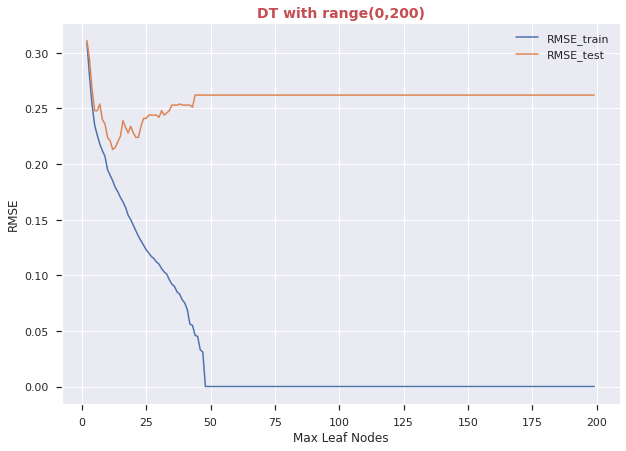

In [195]:
x = np.arange(2, 200)
ax = sns.lineplot(x=x, y=RMSE3_train)
sns.lineplot(x=x, y=RMSE3_test, ax=ax)
ax.legend(labels=['RMSE_train', 'RMSE_test'], bbox_to_anchor=(1, 1))
ax.set_xlabel('Max Leaf Nodes')
ax.set_ylabel('RMSE')
ax.set_title('DT with range(0,200)', c='r', fontdict={'c':'r', 'fontsize':14, 'weight':'bold'})
plt.show()

# Random Forest

Random forest is a type of supervised machine learning algorithm based on decision trees. It is used for both regression and classification tasks. The random forest algorithm works by constructing a multitude of decision trees during training and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.

The advantages of random forests include its ability to handle large datasets with high dimensionality, its scalability, and its ability to handle unbalanced and missing data. It also has low variance and low bias, making it a powerful machine learning algorithm.

The algorithm’s scalability and ability to handle large datasets and high dimensionality make it a powerful machine learning algorithm.Its robustness to unbalanced and missing data also makes it a good choice for many types of applications.

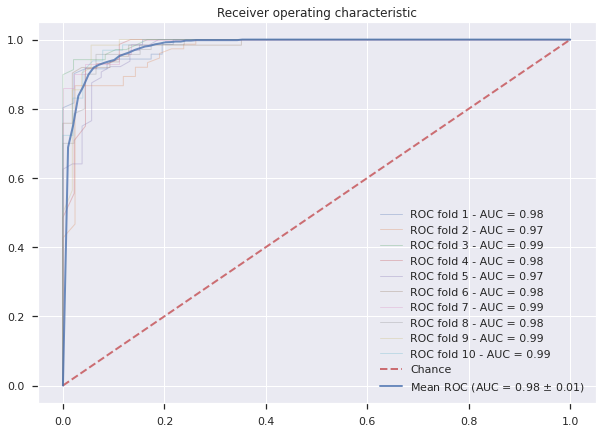

In [196]:
# KFold cross validation with 10 folds
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

# Random Forest Classifier
clf_rfc = RandomForestClassifier(n_estimators=100, random_state=seed)

tprs = []
aucs = []

mean_fpr = np.linspace(0,1,100)

fig, ax = plt.subplots()

for i, (train,test) in enumerate(kfold.split(X,y)):
    clf_rfc.fit(X.loc[train], y[train])
    y_proba = clf_rfc.predict_proba(X.loc[test]) 
    fpr, tpr, _ = roc_curve(y[test], y_proba[:,1])
    
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    
    tprs.append(interp_tpr)
    aucs.append(auc(fpr,tpr))
    
    ax.plot(
        fpr, tpr,
        label='ROC fold ' + str(i+1) +  ' - AUC = ' + str(np.round(auc(fpr,tpr),2)),
        lw=1,
        alpha=0.3)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# Plot mean roc curve auc
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic",
)

ax.legend(loc="lower right")
plt.show()

In [238]:
# Plot feature importance attribute of the Random Forest

importance = pd.DataFrame({'Importance':clf.feature_importances_*100}, 
                          ['popularity','valence','instrumentalness','danceability','liveness','acousticness','loudness','energy'])

importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'red', )

plt.xlabel('Variable Importance')
plt.gca().legend_ = None

AttributeError: ignored

Optimal number of features: 8


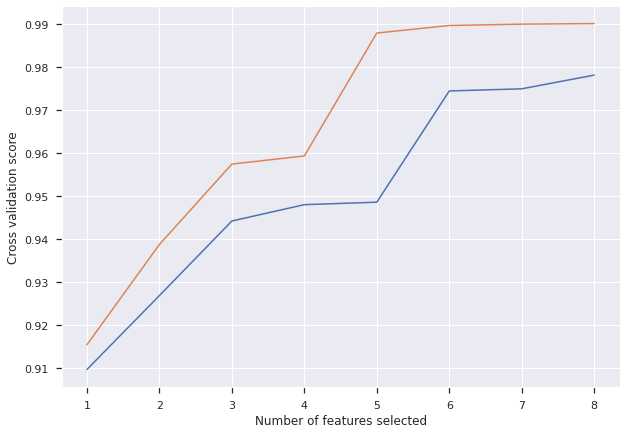

In [201]:
# Cross-validation for number of features
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rfecv = RFECV(estimator=rf, step=1, n_jobs=-1, cv=StratifiedKFold(2), verbose=1, scoring='roc_auc')
rfecv.fit(X_train, y_train)

print(f'Optimal number of features: {rfecv.n_features_}')

plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score')
plt.plot(range(1, len(rfecv.grid_scores_)+1), rfecv.grid_scores_)
plt.show()

In [202]:
# Analyze feature importances

rfc = RandomForestClassifier(n_estimators = 500, max_depth=4, random_state=42)
rfc.fit(X_train, y_train)

important_features_dict = {}
for idx, val in enumerate(rfc.feature_importances_):
    important_features_dict[idx] = val

important_features_list = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)

for i in range(len(important_features_list[:8])):
    print(f"{i+1}. {X_train.columns[important_features_list[i]]} {important_features_dict[important_features_list[i]]}")

1. instrumentalness 0.23780015293106752
2. acousticness 0.2240804997541483
3. loudness 0.18799848827920243
4. energy 0.13929045712633123
5. popularity 0.10980622076108713
6. danceability 0.07729257455464293
7. valence 0.01618432538179483
8. liveness 0.007547281211725569


In [198]:
def Randomforest(X_train,y_train,X_test,y_test):
    clf = RandomForestRegressor()
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    accuracy = clf.score(X_test, y_test)
    mae = (abs(y_test - preds)).mean() 
    y_train_pred = clf.predict(X_train)
    y_test_pred = tree.predict(X_test)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test= r2_score(y_test, y_test_pred)
    return accuracy,mae,r2_train,r2_test

accuracy,mae,r2_train,r2_test =  Randomforest(X_train,y_train,X_test,y_test)
print("Test Accuracy: {:.4f}".format(accuracy*100))
print("Mean Absolute Error: {:.4f} ".format(mae))
print("r2-score of Train Dataset is {} and Test Dataset is {}".format(r2_train*100, r2_test*100))

Test Accuracy: 84.7289
Mean Absolute Error: 0.0864 
r2-score of Train Dataset is 97.80840230863848 and Test Dataset is 71.46793203734885


In [199]:
# Random Forest Classifier
rfc = RandomForestClassifier(n_estimators = 1000, random_state=42)
rfc_gcv_parameters = {'min_samples_leaf': [1, 3, 5, 8], 
                      'max_depth': [3, 4, 5, 8, 12, 16, 20], 
                     }
rfe_gcv = GridSearchCV(rfc, rfc_gcv_parameters, n_jobs=-1, cv=StratifiedKFold(2), verbose=1, scoring='roc_auc')
rfe_gcv.fit(X_train, y_train)
rfe_gcv.best_estimator_, rfe_gcv.best_score_

Fitting 2 folds for each of 28 candidates, totalling 56 fits


(RandomForestClassifier(max_depth=16, n_estimators=1000, random_state=42),
 0.9840240325480178)

In [200]:
print(classification_report(y_test, rfe_gcv.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.90      0.94        94
           1       0.94      0.99      0.97       139

    accuracy                           0.96       233
   macro avg       0.96      0.95      0.95       233
weighted avg       0.96      0.96      0.96       233



# Bagging Regressor


Bagging Regressor is a type of ensemble learning method used in regression tasks. It is a technique that combines multiple models to form a single, more powerful model. The individual models, or “weak learners”, are trained on subsets of the data and combine their predictions to form a single, stronger prediction. This method is also known as bootstrap aggregation, or bagging.

The main advantage of using bagging regressor is that it reduces the overfitting of individual models. By combining multiple models, the errors of individual models are reduced and the variance in the predictions is reduced. This results in a better overall prediction.

Bagging is useful for datasets with large numbers of outliers. By combining multiple models, the predictions become more robust to outliers. This is because each model may pick up on different patterns in the data, and the combination of these patterns can produce more accurate predictions.
It is an effective machine learning technique for reducing the overfitting of individual models and increasing the accuracy of predictions. It is a simple and efficient method that can be used in a variety of applications.

In [203]:
bagged_df = RandomForestRegressor(max_features= len(X.columns),
                                  random_state = seed)
bagged_df.fit(X_train, y_train)

y_pred = bagged_df.predict(X_test)
mserror = mse(y_test, y_pred)
print('Mean Squared Error = ' + str(mserror))

Mean Squared Error = 0.03713905579399141


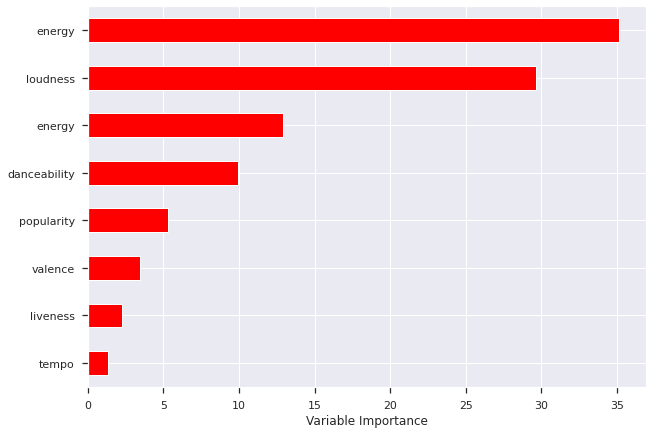

In [204]:
importance = pd.DataFrame({'Importance': bagged_df.feature_importances_*100},
                          index = X.columns)

importance.sort_values(by = 'Importance',
                       axis = 0,
                       ascending = True).plot(kind = 'barh',
                                             color = 'red', )

plt.xlabel('Variable Importance')
plt.gca().legend_ = None

[Text(0.753656914893617, 0.95, 'energy <= 0.372\ngini = 0.49\nsamples = 587\nvalue = [400, 532]'),
 Text(0.5498670212765957, 0.85, 'popularity <= 0.523\ngini = 0.255\nsamples = 395\nvalue = [93, 527]'),
 Text(0.3178191489361702, 0.75, 'energy <= 0.675\ngini = 0.473\nsamples = 133\nvalue = [80, 129]'),
 Text(0.14627659574468085, 0.65, 'valence <= 0.312\ngini = 0.486\nsamples = 81\nvalue = [73, 52]'),
 Text(0.0425531914893617, 0.55, 'energy <= 0.3\ngini = 0.108\nsamples = 21\nvalue = [33, 2]'),
 Text(0.02127659574468085, 0.45, 'gini = 0.0\nsamples = 18\nvalue = [32, 0]'),
 Text(0.06382978723404255, 0.45, 'danceability <= -12.591\ngini = 0.444\nsamples = 3\nvalue = [1, 2]'),
 Text(0.0425531914893617, 0.35, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(0.0851063829787234, 0.35, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.25, 0.55, 'loudness <= 0.015\ngini = 0.494\nsamples = 60\nvalue = [40, 50]'),
 Text(0.14893617021276595, 0.45, 'liveness <= 0.089\ngini = 0.219\nsamples = 19\n

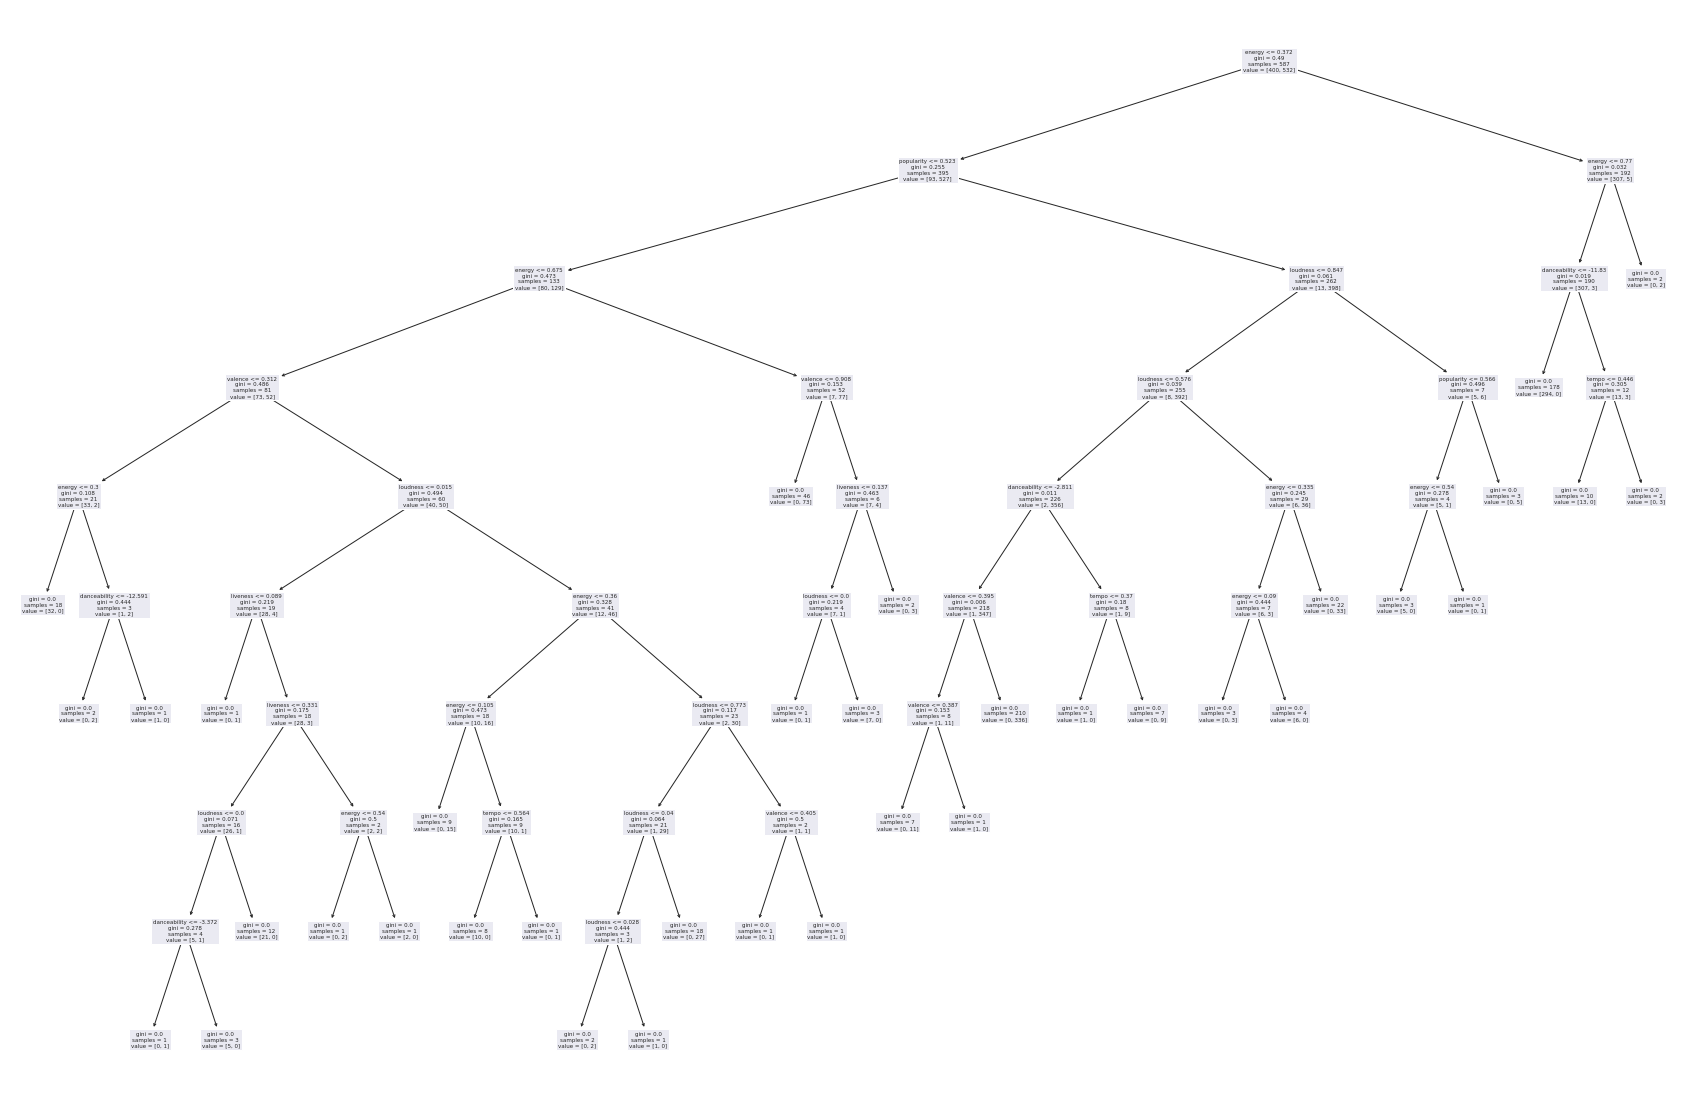

In [205]:
clf = BaggingClassifier(n_estimators = 8, oob_score = True,random_state = 22)
clf.fit(X_train, y_train)
plt.figure(figsize=(30, 20))
plot_tree(clf.estimators_[0], feature_names = X.columns)

#Gradient Booster Regressor

Gradient Boosting Regressor is a powerful ensemble machine learning technique used for regression tasks. It is a type of boosting algorithm that combines multiple weak learners, such as decision trees, to create a more powerful model. The weak learners are trained sequentially and each subsequent learner is trained to correct the errors of the previous learner. This results in a more powerful, accurate model.

The main advantage of using gradient boosting regressor is its ability to produce highly accurate predictions. It is particularly useful when dealing with large datasets and high-dimensional datasets. It is also able to handle large amounts of noise and outliers. Additionally, it is relatively easy to tune the parameters of gradient boosting regressor to improve its performance.

Overall, gradient boosting regressor is a powerful machine learning technique that can be used to produce highly accurate predictions. It is particularly useful when dealing with large datasets and high-dimensional datasets. Additionally, it is relatively easy to tune the parameters of gradient boosting regressor to improve its performance.

In [206]:
boosted_boston = GradientBoostingRegressor(n_estimators = 100, 
                                           learning_rate = 0.05, 
                                           max_depth = 3, 
                                           random_state = 1)

boosted_boston.fit(X_train, y_train)

y_pred = boosted_boston.predict(X_test)
mserror = mse(y_test, y_pred)
print("MSE: %.2f" % mserror)
print("The best accuracy on training set: %.3f" % boosted_boston.score(X_train, y_train))
print("The best accuracy on test set: %.3f" % boosted_boston.score(X_test, y_test))

MSE: 0.04
The best accuracy on training set: 0.921
The best accuracy on test set: 0.832


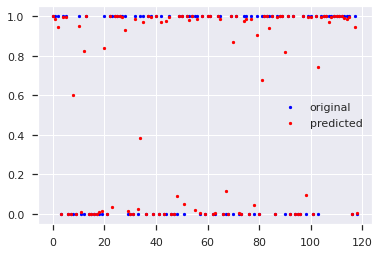

In [240]:
x_ax = range(len(y_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.scatter(x_ax, y_pred, s=5, color="red", label="predicted")
plt.legend()
plt.show()

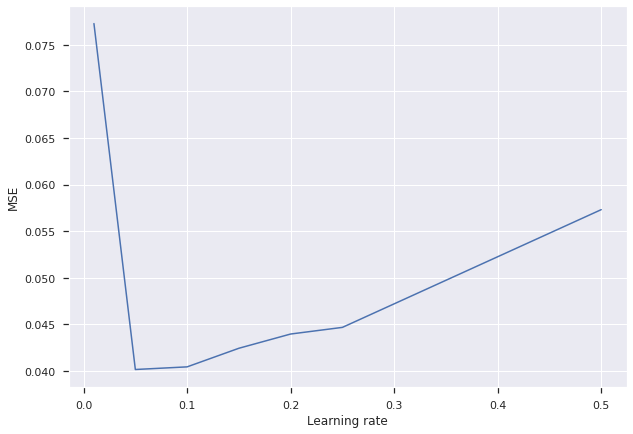

In [208]:
tuned_parameters = [{'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5]}]
clf = GridSearchCV(GradientBoostingRegressor(), tuned_parameters, cv=10, scoring='neg_mean_squared_error')
clf.fit(X_train,y_train)

cv_results = pd.DataFrame(clf.cv_results_)
plt.plot(cv_results['param_learning_rate'], -1*cv_results['mean_test_score'])
plt.xlabel('Learning rate')
plt.ylabel('MSE')
plt.show()

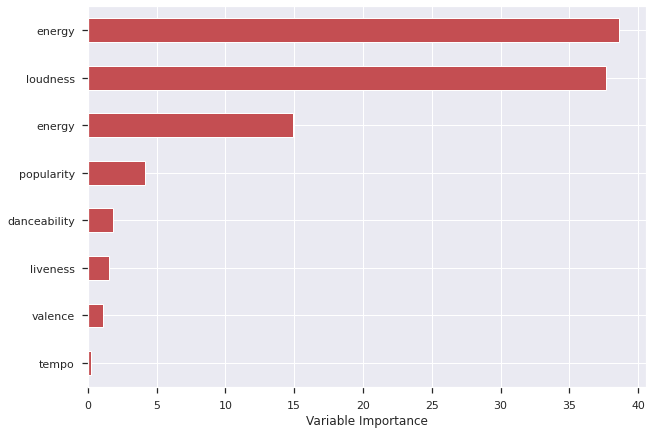

In [209]:
feature_importance = boosted_boston.feature_importances_*100

rel_imp = pd.Series(feature_importance, index = X.columns).sort_values(inplace = False)

rel_imp.T.plot(kind = 'barh', 
               color = 'r', )

plt.xlabel('Variable Importance')

plt.gca().legend_ = None

# Support Vector Machines


Support Vector Machines (SVMs) are a type of supervised machine learning algorithm used for both classification and regression tasks. SVMs are based on the concept of decision planes that define decision boundaries. These boundaries are used to classify data points into different categories.

SVMs have several advantages over other machine learning models, such as being more robust against overfitting, having a greater ability to capture complex boundaries and having the ability to use multiple kernel functions, allowing for a more flexible decision surface.

The basic idea behind SVMs is to find a hyperplane that best separates the data points into two classes. This hyperplane is then used to classify data points that are on either side of it. The hyperplane is determined by the support vectors, which are data points that are closest to the hyperplane.

The model is then trained using a variety of techniques, such as the use of kernels, which are functions that measure the similarity between two data points, and regularization, which is used to prevent overfitting.

In addition to being used for classification, SVMs can also be used for regression tasks, where the goal is to predict a continuous target variable. This is done by finding a hyperplane that is closest to all of the data points.

In [210]:
!lib5c pipeline

/bin/bash: lib5c: command not found


In [211]:
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier

svm_clf = OneVsRestClassifier(LinearSVC(C=1, loss = "hinge", random_state = 1))
svm_clf.fit(X_train, y_train)

SVCpipe = Pipeline([('scale', StandardScaler()),
                   ('SVC',LinearSVC())])# Gridsearch to determine the value of C
param_grid = {'SVC__C':np.arange(0.01,100,10)}
linearSVC = GridSearchCV(SVCpipe,param_grid,cv=5,return_train_score=True)
linearSVC.fit(X_train,y_train)
print(linearSVC.best_params_)


{'SVC__C': 80.01}


In [212]:
svm_clf = OneVsRestClassifier(LinearSVC(C=0.01, loss = "hinge", random_state=1))
preds=svm_clf.fit(X_train,y_train)
preds = svm_clf.predict(X_train)
from sklearn.metrics import classification_report
print(classification_report(y_train,preds))

              precision    recall  f1-score   support

           0       0.98      0.77      0.87       390
           1       0.86      0.99      0.92       542

    accuracy                           0.90       932
   macro avg       0.92      0.88      0.89       932
weighted avg       0.91      0.90      0.90       932



--

In [213]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [214]:
from sklearn.decomposition import PCA 
from sklearn.svm import SVC
pca = PCA(n_components=2)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

svm=SVC(C=1, kernel='linear', gamma=0.1)
svm.fit(X_train, y_train)

SVC(C=1, gamma=0.1, kernel='linear')

In [246]:
from sklearn.model_selection import GridSearchCV

parameters = [{'C':[0.01, 0.1, 1, 10, 50, 100, 500, 1000], 'kernel':[ 'linear','rbf'], 'gamma': [0.1, 0.125, 0.15, 0.17, 0.2]}]
grid_search = GridSearchCV(estimator=svm, param_grid=parameters, scoring = 'accuracy', cv=5, n_jobs=-1)
grid_search = grid_search.fit(X_train, y_train)

best_accuracy = grid_search.best_score_
opt_param = grid_search.best_params_

print('Best accuracy achieved: ', best_accuracy)
print('Optimal params: ', opt_param)

Best accuracy achieved:  0.9558282208588956
Optimal params:  {'C': 50, 'gamma': 0.15, 'kernel': 'rbf'}


In [250]:
from sklearn.svm import SVC

# Function to draw a nice plot of an SVM
def plot_svc(svc, X, y, h=0.02, pad=0.25):
    
    x_min, x_max = X[:, 0].min()-pad, X[:, 0].max()+pad
    y_min, y_max = X[:, 1].min()-pad, X[:, 1].max()+pad
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.2)

    plt.scatter(X[:,0], X[:,1], s=70, c=y, cmap=mpl.cm.Paired)
    
    # Support vectors indicated in plot by vertical lines
    sv = svc.support_vectors_
    plt.scatter(sv[:,0], sv[:,1], c='k', marker='x', s=100, linewidths=1)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()
    print('Number of support vectors: ', svc.support_.size)

import matplotlib as mpl
svc1 = SVC(C=50, kernel='rbf', gamma=0.15)
svc1.fit(X_test, y_test)
plot_svc(svc1, X_test, y_test)    

TypeError: ignored

# Neural Network


Neural networks are a type of artificial intelligence technology that is modeled after the human brain's structure and function. They are commonly used to recognize patterns, classify data, and make predictions. Neural networks are composed of multiple layers of interconnected nodes, each of which performs a simple mathematical operation. The nodes are connected in a way that allows information to flow from input to output.

Neural networks are becoming increasingly popular because they are able to learn from data. This means that they can adapt to changing conditions and environments, and even make predictions about the future. This makes them a powerful tool for artificial intelligence applications.

Neural networks are also fairly easy to set up and use. They require only basic programming skills, and can be implemented in a variety of languages. This makes them a great choice for hobbyists and professionals alike.

Overall, neural networks are a powerful tool for solving a wide variety of problems. They are easy to set up and use, and can learn from data. This makes them a great choice for artificial intelligence applications.

In [217]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

In [218]:
# Assign the input and output vectors
X = df.drop(columns = ['like', 'id', 'title', 'all_artists', 'release_date'])
y = df[['like']]

# Normalize Data
from sklearn.preprocessing import MinMaxScaler

## Create the transformer from the input matrix
transformer_X = MinMaxScaler().fit(X)
X_norm = pd.DataFrame(transformer_X.transform(X), columns = X.columns)

## Create the transformer from the output vector
transformer_y = MinMaxScaler().fit(y)
y_norm = pd.DataFrame(transformer_y.transform(y), columns = ['like'])


# 70% of the data is for training, 20% for validation and 10% for test
X_train, X_val, y_train, y_val = train_test_split(X_norm, y_norm, train_size = 0.7, random_state = seed)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, train_size = 0.66, random_state = seed)

In [219]:
# Determine the number of input features
n_features = X_train.shape[1]

# [first hidden layer, second hidden layer, learning rate, epochs, batch size]
params = [[20, 10, 1e-4, 1500, 16],
          [20, 10, 1e-4, 1500, 32],
          [10, 5, 1e-4, 1500, 32],
          [5, 3, 1e-4, 1500, 16]]

results_df = pd.DataFrame(columns = ['resid', 'x_axis', 'label'])
losses_df = pd.DataFrame(columns = ['epoch', 'loss', 'val_loss', 'label'])

for i in range(len(params)):
    
    # Print iteration
    print('Iteration {}/{}'.format(i+1, len(params)))
    
    # Define model
    model = Sequential()
    model.add(Dense(params[i][0], activation='relu', input_shape=(n_features,)))
    model.add(Dense(params[i][1], activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Define the optimizer
    model.compile(
        optimizer = Adam(learning_rate=params[i][2]),
        loss = MeanSquaredError()
    )

    # Fit the model
    history = model.fit(X_train, y_train, epochs=params[i][3], batch_size=params[i][4],
                        verbose=0, validation_data=(X_val, y_val))
    # Store the values
    yhat = model.predict(X_test)
    resid = transformer_y.inverse_transform(yhat) - transformer_y.inverse_transform(y_test)
    x_axis = transformer_y.inverse_transform(y_test)
    
    results_df = results_df.append(
        pd.DataFrame(data = {
            'resid': resid.reshape(-1,),
            'x_axis': x_axis.reshape(-1,),
            'label': ','.join([str(j) for j in params[i]])
        })
    )
    
    losses_df = losses_df.append(
        pd.DataFrame(data = {
            'epoch': [(i // 10)*10 for i in history.epoch], 
            'loss': history.history['loss'],
            'val_loss': history.history['val_loss'],
            'label': ','.join([str(j) for j in params[i]])
        })
    ) 


Iteration 1/4
4/4 [==============================] - 0s 3ms/step
Iteration 2/4
4/4 [==============================] - 0s 4ms/step
Iteration 3/4
4/4 [==============================] - 0s 5ms/step
Iteration 4/4
4/4 [==============================] - 0s 3ms/step


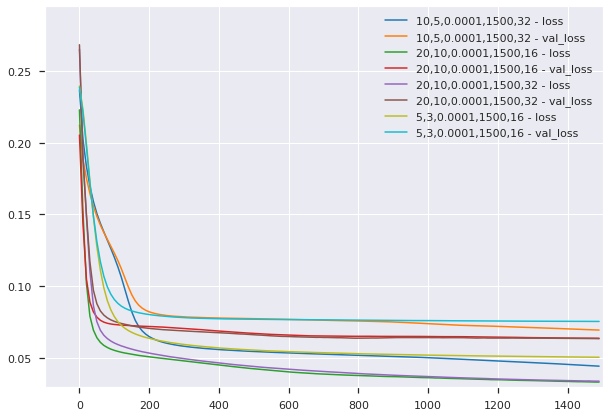

In [220]:
losses = losses_df.groupby(['epoch', 'label']).mean().reset_index().sort_values(by = ['label', 'epoch'])
losses = pd.melt(losses, id_vars = ['epoch', 'label'], value_vars = ['loss', 'val_loss'], var_name = 'test')
losses['label'] = losses['label'] + ' - ' + losses['test']
losses = losses.sort_values(by = ['label', 'epoch'])

labels = losses.label.unique()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red',
         'tab:purple', 'tab:brown', 'tab:olive', 'tab:cyan']

fig, ax = plt.subplots()
for i in range(len(labels)):
    
    idxs = losses.label == labels[i]
    
    ax.plot(
        losses[idxs].epoch, losses[idxs].value, c=colors[i], label=labels[i]
    )

ax.legend()
ax.grid(True)
plt.xlim([-100, 1500])
plt.ylim([losses.value.min()*0.9, losses.value.max()*1.1])

plt.show()

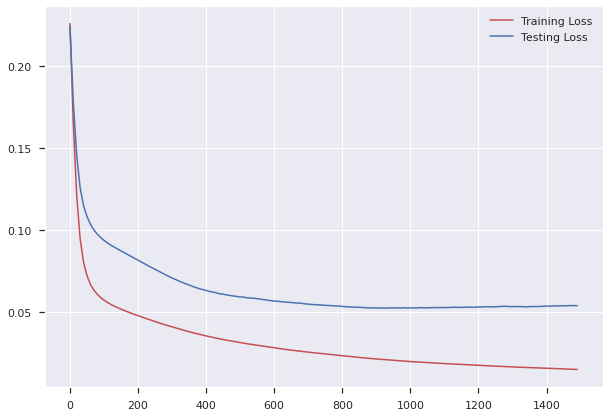

In [221]:
# Chosen Parameters 
# [first hidden layer, second hidden layer, learning rate, epochs, batch size]
c_params = [20, 10, 1e-4, 1500, 16]
         
# Define model
model = Sequential()
model.add(Dense(c_params[0], activation='relu', input_shape=(n_features,)))
model.add(Dense(c_params[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Define the optimizer
model.compile(
    optimizer = Adam(learning_rate=c_params[2]),
    loss = MeanSquaredError()
)

# Fit the model
history  = model.fit(X_train, y_train, epochs=c_params[3], batch_size=c_params[4], verbose=0, validation_data=(X_test, y_test))


losses = pd.DataFrame(data = {
    'epoch': [(i // 10) * 10 for i in history.epoch],
    'loss': history.history['loss'],
    'val_loss': history.history['val_loss']
})
losses = losses.groupby(by = 'epoch').mean().reset_index()

plt.plot(losses.epoch, losses.loss, 'r-', label = 'Training Loss')
plt.plot(losses.epoch, losses.val_loss, 'b-', label = 'Testing Loss')
plt.legend()
plt.show()


In [222]:
# Confusion Matrix and Accuracy
from sklearn.metrics import confusion_matrix, accuracy_score

## Training
y_pred = model.predict(X_train)
print('Training Confusion Matrix')
print(confusion_matrix(y_train, y_pred.round()))
print(accuracy_score(y_train, y_pred.round()))

## Test
y_pred = model.predict(X_test)
print('\nTest Confusion Matrix')
print(confusion_matrix(y_test, y_pred.round()))
print(accuracy_score(y_test, y_pred.round()))

26/26 [==============================] - 0s 1ms/step
Training Confusion Matrix
[[337  12]
 [  1 465]]
0.9840490797546012
4/4 [==============================] - 0s 3ms/step

Test Confusion Matrix
[[45  6]
 [ 3 65]]
0.9243697478991597


# Essemble

In order to get a better view of the model to use

In [223]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
log_clf = OneVsRestClassifier(LogisticRegression(max_iter=1000, penalty = "l2", C=1, random_state=1))
rnd_clf = RandomForestClassifier(random_state=1)
svm_clf = OneVsRestClassifier(LinearSVC(C=0.01, loss = "hinge", random_state = 1))
voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)])
voting_clf=voting_clf.fit(X_train, y_train)
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    ypred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, ypred))

OneVsRestClassifier 0.8739495798319328
RandomForestClassifier 0.9243697478991597
OneVsRestClassifier 0.865546218487395
VotingClassifier 0.8823529411764706


# Prediction


It is now possible to create a music recommendation system using Python and the Spotify API in Google Colab. By collecting and analyzing the necessary data, and then implementing the model using machine learning algorithms, we can create a system that will identify the most suitable music for the user from a random playlist.


In [254]:
# Predict
df_guess_copy=df_guess.copy()
df_guess_copy['like'] =clf_rfc.predict(df_guess)
df_guess_copy['prob_like'] =clf_rfc.predict_proba(df_guess)[:,1]  # slice for probability of 1
#df_guess_copy[df_guess_copy['like'] == 1].head(100)
n_likes= df_guess_copy[df_guess_copy['prob_like']  <= 0.2]
likes= df_guess_copy[df_guess_copy['prob_like']  >= 0.5]
a=likes.sort_values("prob_like",ascending=False)
b = pd.DataFrame([])
b=b.append(df_play.iloc[a.index])
b['like']=a['prob_like']
b= b.drop_duplicates(subset='id', keep="first").reset_index()
b=b.drop(['id','index','Unnamed: 0','release_date', 'danceability', 'energy', 'key', 
                             'loudness', 'mode', 'acousticness', 
                             'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature'],axis=1)        
b[:5]


,title,all_artists,popularity,like
0,Tan Kalakatan,Mayra Andrade,40,0.64
1,"Hello, Anxiety (STUTS Remix)",STUTS,26,0.57
2,Sempre Bem,Capitão Fausto,38,0.57
3,Ddoje Facce,Nu Genea,54,0.57
4,These Boots Are Made For Walkin',Maria De Medeiros,33,0.57
